## Connect to sqlite database (if necessary)

In [1]:
#work with sqlite database

#import sqlite3

#conn = sqlite3.connect('database.sqlite')
#c = conn.cursor()
#artists = c.execute('''SELECT * FROM artists''').fetchall()

#conn.commit()
#conn.close()

## Connect to Postgres database

In [2]:
#import necessary modules

import psycopg2
import pandas as pd
import numpy as np

#create connection
conn = psycopg2.connect('dbname=pitchfork_reviews')
cur = conn.cursor()

#execute simple commands
cur.execute("""
SELECT * FROM genres;
""")

genres = cur.fetchall()

## 1. Is there a statistical difference between 'metal' and 'jazz' music genres? 

The first step is to choose what genres to compare. 

In [3]:
#load cast genres into a dataframe
df_genres = pd.DataFrame(genres)

#check unique values in genres
df_genres[1].unique()

array(['electronic', 'metal', 'rock', None, 'rap', 'experimental',
       'pop/r&b', 'folk/country', 'jazz', 'global'], dtype=object)

Let's choose **metal** and **jazz** genres to see if there is a statistical difference within reviews.

In [4]:
#check how many data entries we have for each genre
df_genres[1].value_counts()

rock            9436
electronic      3874
experimental    1815
rap             1559
pop/r&b         1432
metal            860
folk/country     685
jazz             435
global           217
Name: 1, dtype: int64

### Create a dataframe for reviews scores for 'metal' genre

In [5]:
#make a query from Postgres database to retrieve review scores for 'metal' genre

cur.execute("""
SELECT reviews.reviewid, reviews.score, genres.genre FROM reviews
INNER JOIN genres ON reviews.reviewid = genres.reviewid
WHERE genres.genre = 'metal';
""")

metal = cur.fetchall()
len(metal)

862

In [6]:
#cast query result into a dataframe
metal_df = pd.DataFrame(metal, columns=['id', 'score', 'genre'])

In [7]:
len(metal_df)

862

### It seems that there 2 more rows than unique values for metal genre (862 in database query vs. 860 in rows where genre is 'metal)

In [8]:
#check number of unique values in our dataframe
len(metal_df['id'].unique())

859

In [9]:
#see if the duplicates have all the same values for score columns
metal_df[metal_df.id==9460]

,id,score,genre
555,9460,7.8,metal
556,9460,7.8,metal
557,9460,7.8,metal
558,9460,7.8,metal


In [10]:
#drop duplicates

metal_df.drop_duplicates(subset ="id", 
                     keep='first', inplace = True) 

In [11]:
#check if we have just one value for id=9460
metal_df[metal_df.id==9460]

,id,score,genre
555,9460,7.8,metal


### Create a dataframe for reviews scores for 'jazz' genre

In [12]:
#make a query from Postgres database to retrieve review scores for 'jazz' genre

cur.execute("""
SELECT reviews.reviewid, reviews.score, genres.genre FROM reviews
INNER JOIN genres ON reviews.reviewid = genres.reviewid
WHERE genres.genre = 'jazz';
""")

jazz = cur.fetchall()
len(jazz)

435

In [13]:
#cast query result into a dataframe
jazz_df = pd.DataFrame(jazz, columns=['id', 'score', 'genre'])

In [14]:
#check output
jazz_df.head()

,id,score,genre
0,22707,9.0,jazz
1,22664,8.0,jazz
2,22660,5.2,jazz
3,22639,8.7,jazz
4,22652,7.0,jazz


In [15]:
#check for id duplicates 
len(jazz_df['id'].unique())

435

In [16]:
#close connection to database

#conn.commit()
#conn.rollback()

### Hypothesis testing

To compare 'metal' and 'jazz' scores we will look at the means of these two groups. We will assume that confidence level is 95%.

**Null hypothesis**: there is no statistical difference between reviews scores for 'metal' and 'jazz' genres, that is, the difference in means is equal to 0

**Alternative Hypothesis**: there is difference between reviews scores for 'metal' and 'jazz' genres: the difference in means is not equal to 0.

**Assumptions**:
- data is independent
- data collected randomely
- data is approximately normally distribuited

In [17]:
#check distribution of our data
import matplotlib.pyplot as plt

plt.hist(metal_df['score']);

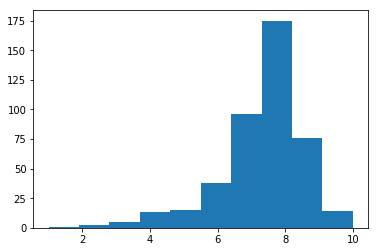

In [18]:
plt.hist(jazz_df['score']);

According to the plots of the distributions we can assume that data is approximately normally distribuited

In [19]:
#calculate the means for 2 groups

metal_mean = metal_df['score'].mean()
jazz_mean = jazz_df['score'].mean()
print('Mean for metal genre is: ', metal_mean)
print('Mean for jazz genre is: ', jazz_mean)

Mean for metal genre is:  6.9470314318975515
Mean for jazz genre is:  7.303908045977015


In [20]:
diff_means = metal_mean - jazz_mean
print('Difference in means is: ', diff_means)

Difference in means is:  -0.3568766140794635


In [21]:
#import fnctions module to compute t-statistic
import functions

t_stat = functions.twosample_tstatistic(metal_df['score'], jazz_df['score'])
t_stat                                                        

-4.5106654344463575

In [22]:
from scipy import stats

#calculate t-test statistic and p-value using scipy library
t_stat_check, p_value = stats.ttest_ind(metal_df['score'], jazz_df['score'])

In [23]:
t_stat_check

-4.510665434446266

In [24]:
p_value

7.0494843399548315e-06

In [25]:
#compare p-value with significance level
print(p_value < 0.05)

True


### Conclusion

P-value is very small in our case which indicates that given null hypothesis is true, the probability that the results from the data we have would be due to a random chance. The probability of that is small enough to be able to reject the null hypothesis. So we can reject the null hypothesis and say that there is difference between review scores of 'metal' genre and 'jazz' genre.



## 2. If the same person does the review, does he/she score genres differently, in particular, 'metal' and 'jazz' genres?


To answer this questions we will perform a 2-tailed paired t-test to see if multigenre reviewrs produce different review scores for 'metal' and 'jazz' genres in particular, since these genres are very different.

**Null hypothesis**: the mean difference between paired observations is equal to zero

**Alternative hypothesis**: the mean difference between paired observations is not equal to zero

Confidence level: 95%

### Retrieve data

In [26]:
#create a dataframe
cur.execute("""
SELECT reviews.reviewid, reviews.author, reviews.score, genres.genre FROM reviews
INNER JOIN genres ON reviews.reviewid = genres.reviewid
WHERE genres.genre = 'jazz' OR genres.genre = 'metal';
""")

reviews = cur.fetchall()
df_reviews = pd.DataFrame(reviews)
df_reviews.columns = [i[0] for i in cur.description]

In [27]:
#check if there are duplicates on ids
len(df_reviews['reviewid']) == len(df_reviews['reviewid'].unique())

False

In [28]:
#drop duplicates
df_reviews.drop_duplicates(subset ="reviewid", 
                     keep='first', inplace = True) 

In [29]:
#check if there are duplicates on ids again after removing duplicates
len(df_reviews['reviewid']) == len(df_reviews['reviewid'].unique())

True

In [30]:
df_reviews.head()

,reviewid,author,score,genre
0,22721,zoe camp,7.9,metal
1,22702,sam sodomsky,7.5,metal
2,22707,seth colter-walls,9.0,jazz
3,22559,savy reyes-kulkarni,7.7,metal
4,22664,philip sherburne,8.0,jazz


In [31]:
#cast dataframe to a dictionry for further transformation
review_dict = df_reviews.to_dict('records')

In [32]:
#create an empty dictionary that will have this structure:
#{'author_name': {'metal_scores': [], 'jazz_scores': []}}

authors_genres_dict = {}

In [33]:
#loop through the review_dict to get the values for authors_genres_dict 
for i in review_dict:
    
    if i['author'] in authors_genres_dict.keys():
        #update dictionary values for this author
        if i['genre'] == 'metal':
            authors_genres_dict[i['author']]['metal_scores'].append(i['score'])
        else:
            authors_genres_dict[i['author']]['jazz_scores'].append(i['score'])
        
    else:
        #add this author name to authors_genres_dict keys
        authors_genres_dict[i['author']] = {'metal_scores': [], 'jazz_scores': []}
        
        if i['genre'] == 'metal':
            authors_genres_dict[i['author']]['metal_scores'].append(i['score'])
        else:
            authors_genres_dict[i['author']]['jazz_scores'].append(i['score'])
        

In [34]:
#remove names that only reviewed one genre out of two
authors_two_genres_dict = {}

for key, value in authors_genres_dict.items():
    if value['metal_scores'] != [] and value['jazz_scores'] != []:
        authors_two_genres_dict[key] = {'metal_scores': np.mean(value['metal_scores']), 'jazz_scores': np.mean(value['jazz_scores'])}
        

In [35]:
authors_two_genres_df = pd.DataFrame.from_dict(authors_two_genres_dict, orient='index')

In [36]:
authors_two_genres_df.head()

,metal_scores,jazz_scores
aaron leitko,6.200000,7.750000
adam moerder,5.866667,2.700000
alex linhardt,9.700000,8.150000
alexander lloyd linhardt,9.000000,8.066667
alison fields,5.860000,6.500000


### Perform a paired t-test using scipy library

In [37]:
t, p = stats.ttest_rel(authors_two_genres_df['metal_scores'], authors_two_genres_df['jazz_scores'])

In [38]:
print('t-statistic is: ', t)

t-statistic is:  -0.5405345553646849


In [39]:
print('p-value is: ', p)

p-value is:  0.5904967100228813


### Conclusion
P-value represents the probability that given the null hypothesis is true, the data we had was the result of random chance. P-value is higher than out significance level aplha=0.05, so we cannot reject the null hypothesis

## 3. Looking at the scores produced by one author, are they different from the average scores given by the total of aythors? That, is any of the authors biased?

### Gather data

In [40]:
#create a dataframe
cur.execute("""
SELECT reviews.reviewid, reviews.author, reviews.score, reviews.pub_date FROM reviews;
""")

reviews_test3 = cur.fetchall()
df_reviews_test3 = pd.DataFrame(reviews_test3)
df_reviews_test3.columns = [i[0] for i in cur.description]

In [41]:
#check if there are duplicates on ids
len(df_reviews['reviewid']) == len(df_reviews['reviewid'].unique())

True

In [42]:
#check rows that have 0.0 review score to see if it is necessary to drop them
cur.execute("""
SELECT * FROM reviews WHERE reviews.score=0;
""")

zero_score_reviews = cur.fetchall()
df_zero_score_reviews = pd.DataFrame(zero_score_reviews)
df_zero_score_reviews.columns = [i[0] for i in cur.description]

df_zero_score_reviews

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year
0,10571,this is next,various artists,http://pitchfork.com/reviews/albums/10571-this...,0.0,0,matt lemay,contributor,2007-08-22,2,22,8,2007
1,9464,shine on,jet,http://pitchfork.com/reviews/albums/9464-shine...,0.0,0,ray suzuki,contributor,2006-10-02,0,2,10,2006
2,6383,relaxation of the asshole,robert pollard,http://pitchfork.com/reviews/albums/6383-relax...,0.0,0,eric carr,contributor,2005-04-20,2,20,4,2005
3,5607,travistan,travis morrison,http://pitchfork.com/reviews/albums/5607-travi...,0.0,0,chris dahlen,None,2004-09-27,0,27,9,2004
4,6255,liz phair,liz phair,http://pitchfork.com/reviews/albums/6255-liz-p...,0.0,0,matt lemay,contributor,2003-06-24,1,24,6,2003
5,7342,nyc ghosts & flowers,sonic youth,http://pitchfork.com/reviews/albums/7342-nyc-g...,0.0,0,brent dicrescenzo,contributor,2000-04-30,6,30,4,2000


After going through the reviews with 0 scores, we came to a conclusion that there is no reason to drop those rows since all but 1 actually have a review text. There is no reason to believe that the score 0 was not chosen intentionally.

In [43]:
#convert date into datetime object
df_reviews_test3.pub_date = df_reviews_test3.pub_date.apply(lambda x: pd.to_datetime(x))

In [44]:
#check if converted correctly
df_reviews_test3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18393 entries, 0 to 18392
Data columns (total 4 columns):
reviewid    18393 non-null int64
author      18393 non-null object
score       18393 non-null float64
pub_date    18393 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 574.9+ KB


In [45]:
#cast dataframe to dictionary
review_dict_test3 = df_reviews_test3.to_dict('records')

In [46]:
import functions

author_scores_dict = functions.get_author_scores(review_dict_test3)

In [47]:
#author_scores_dict

In [69]:
#create a new dictionary with authors who did more than 50 reviews
#the higher the number of reviews, the closer to a normal distribution the data is
author_scores_50 = {}

for key, value in author_scores_dict.items():
    if len(value['scores']) >= 50:
        author_scores_50[key] = value

        
#how many authors are in the dictionary?
len(author_scores_50.keys())

85

In [70]:
#create a dictionary with means per author
author_scores_50_means = {}

for key, value in author_scores_50.items():
    author_scores_50_means[key] = np.mean(value['scores'])

In [71]:
#author_scores_50_means

We will create a function that will perform the following hypothesis test for each author:

**Null Hypothesis**: the mean of the author's review is the same as the population mean (mean of all scores)
**Alternative hypothesis**: the mean of an author's review is different from the population meean

Chosen confidence level: 95%

In [66]:
#calculate popuaition mean and standard deviation

cur.execute("""
SELECT score FROM reviews;
""")

scores = cur.fetchall()
scores_df = pd.DataFrame(scores, columns=['score'])
scores_mean = scores_df['score'].mean()
scores_std = scores_df['score'].std()

In [67]:
scores_mean
scores_std

1.2936745021540692

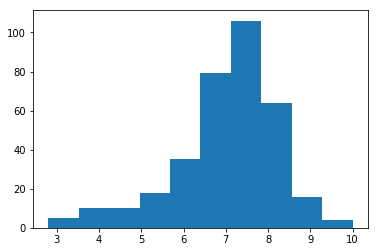

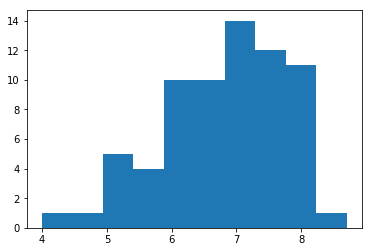

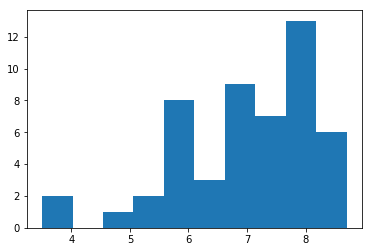

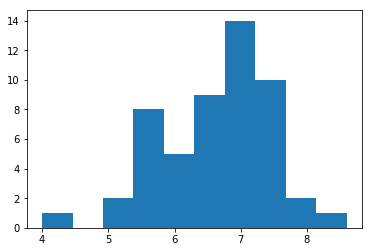

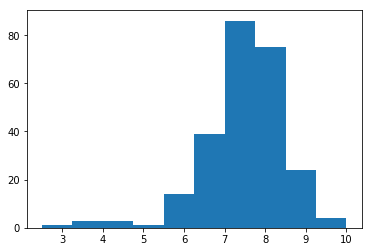

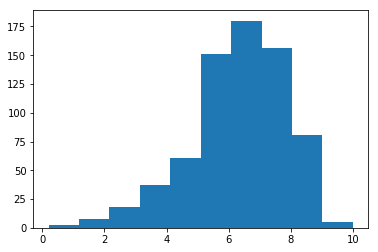

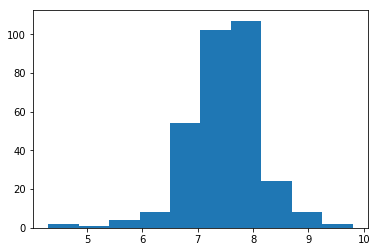

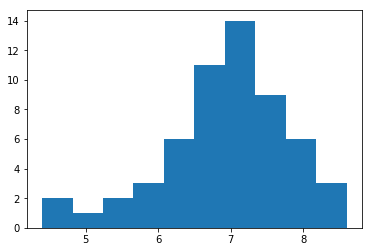

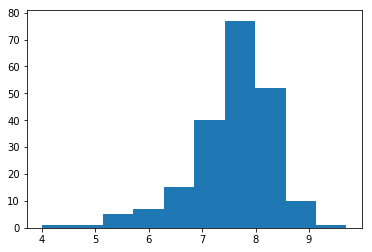

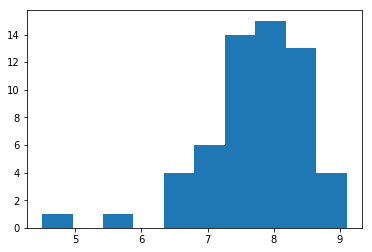

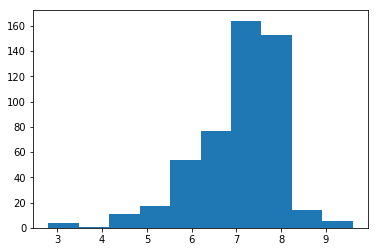

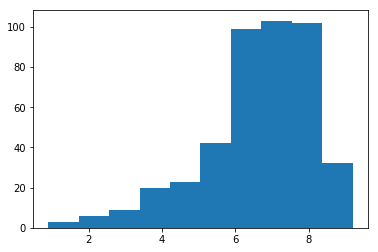

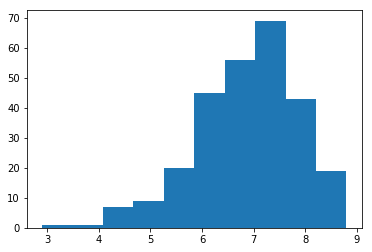

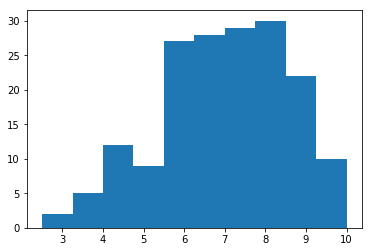

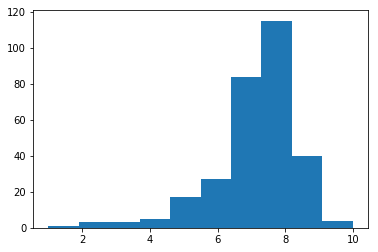

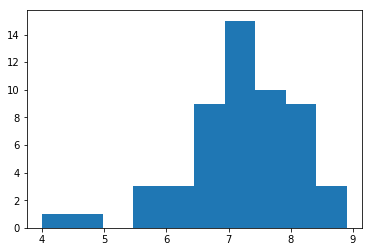

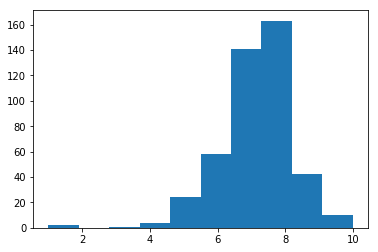

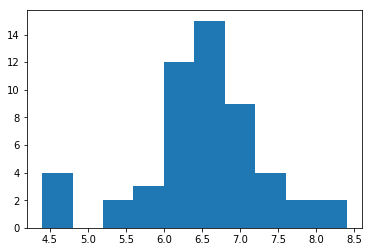

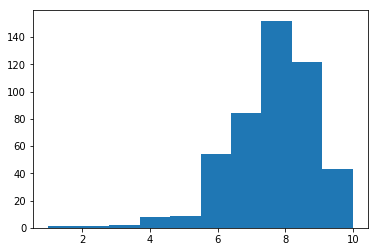

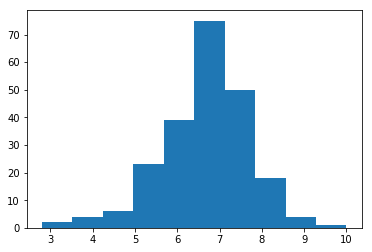

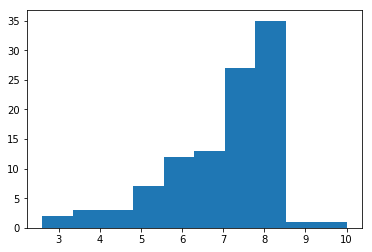

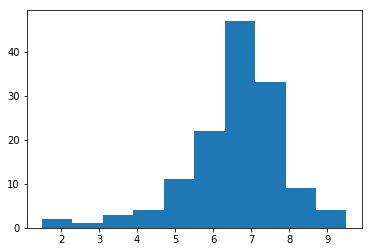

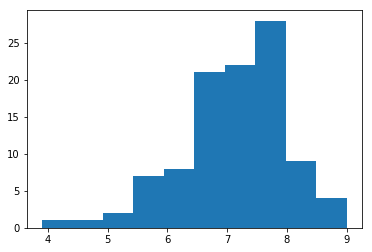

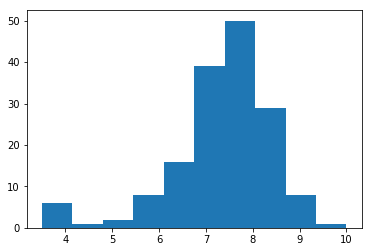

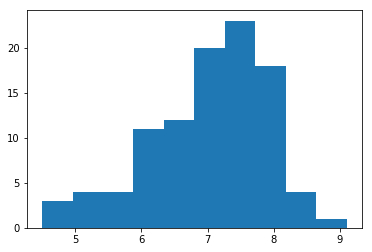

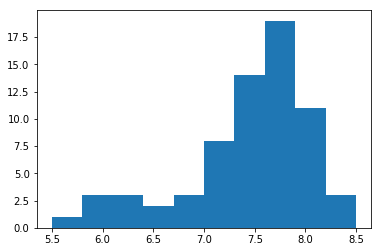

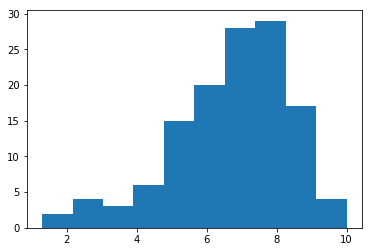

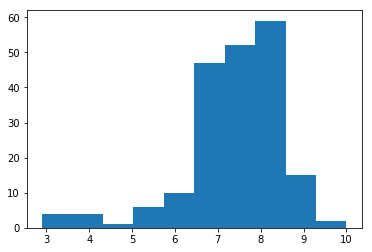

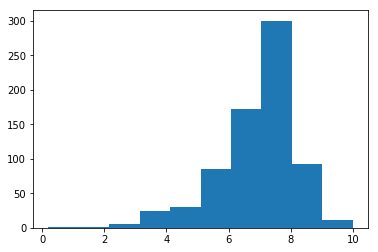

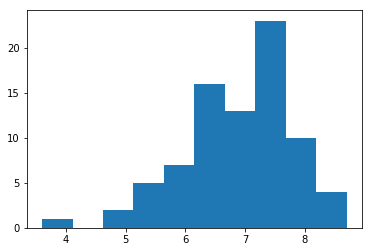

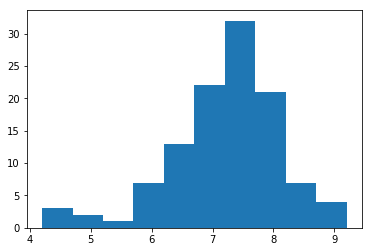

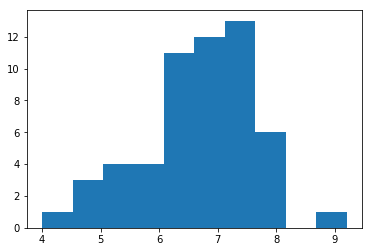

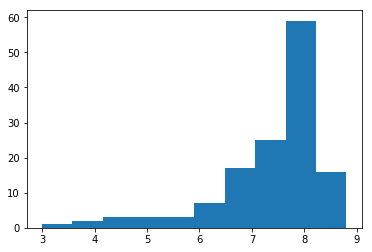

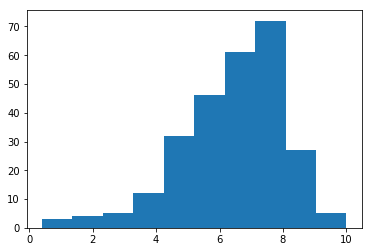

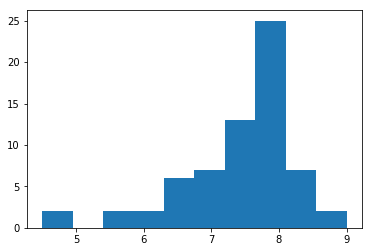

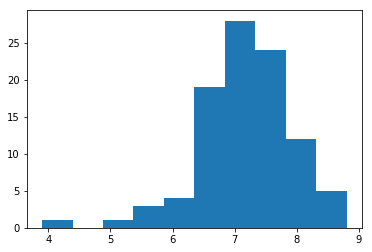

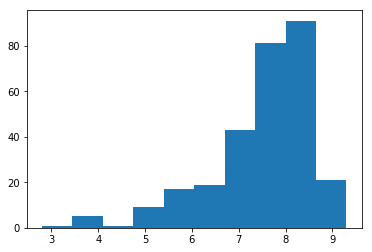

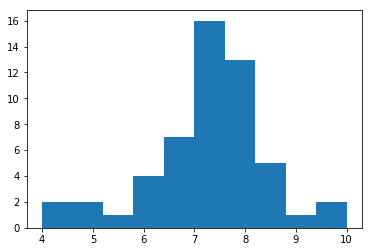

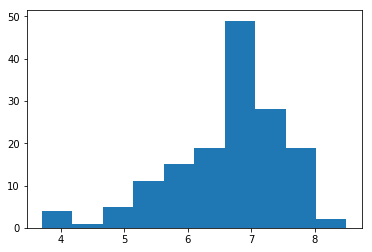

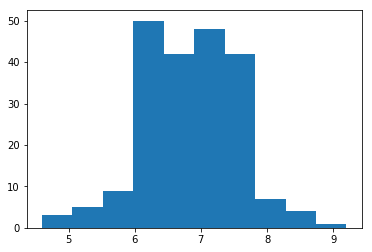

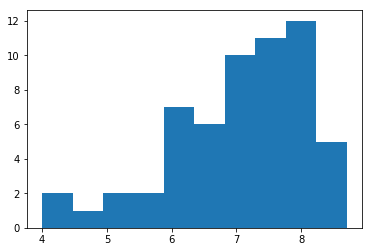

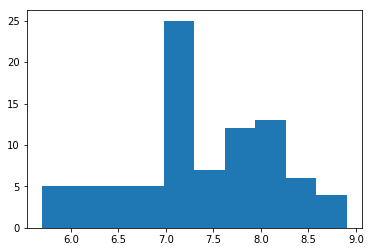

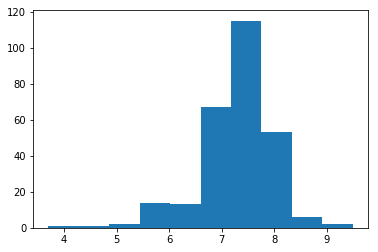

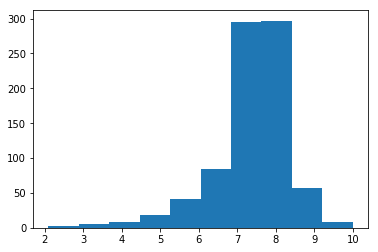

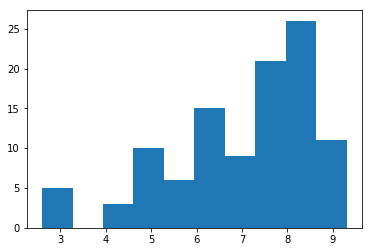

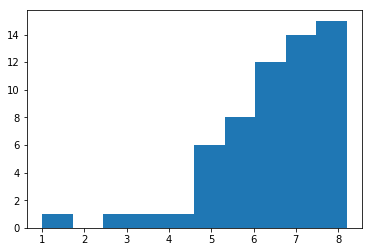

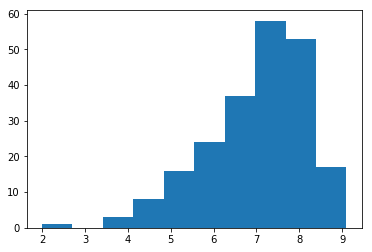

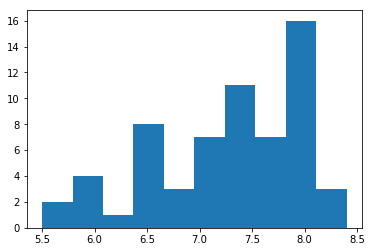

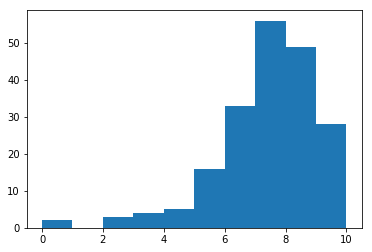

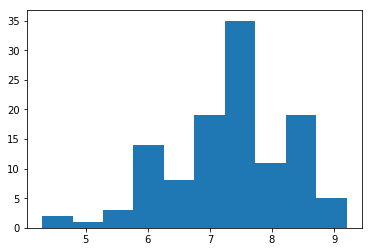

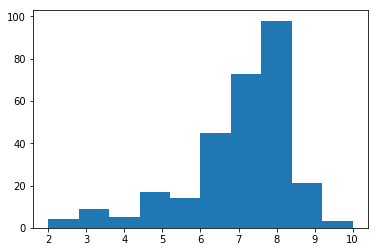

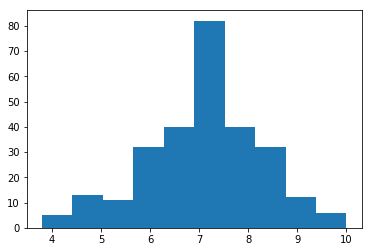

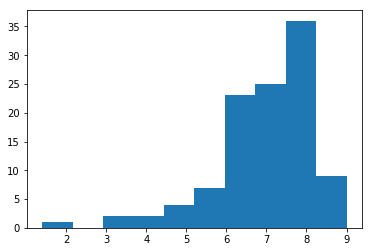

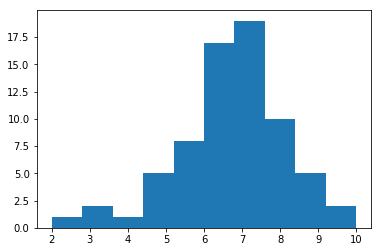

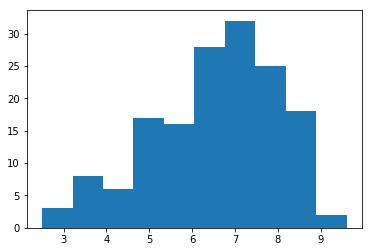

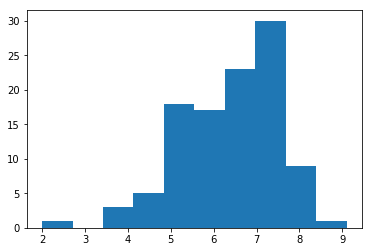

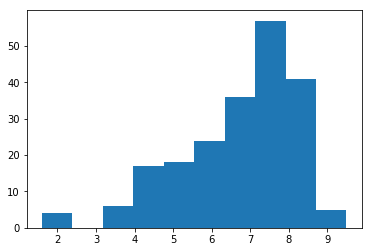

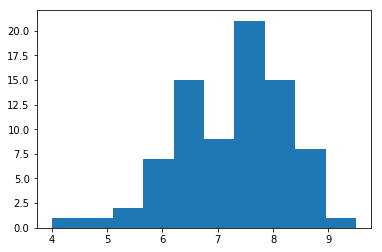

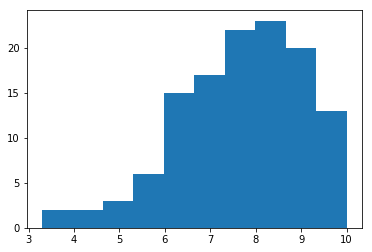

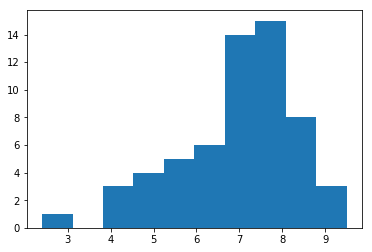

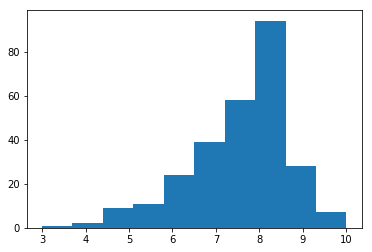

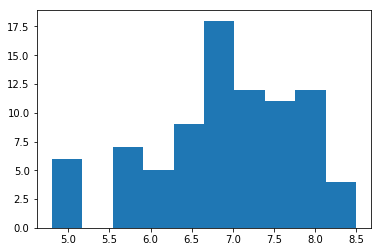

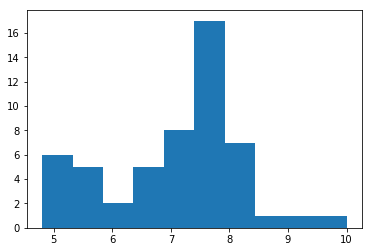

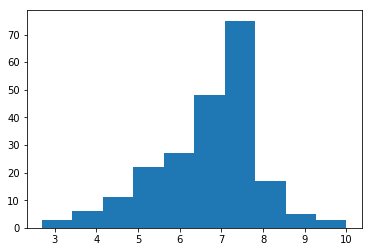

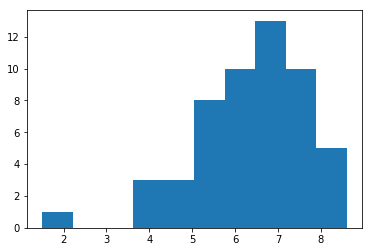

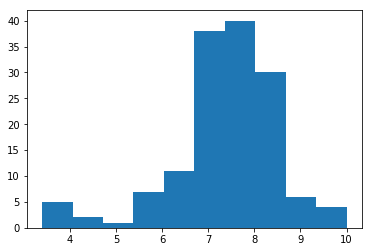

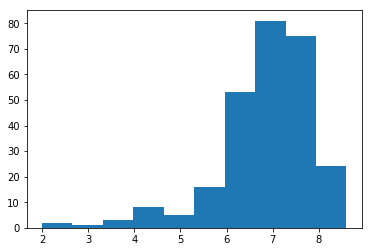

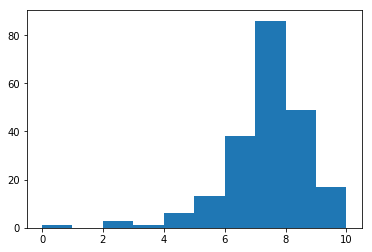

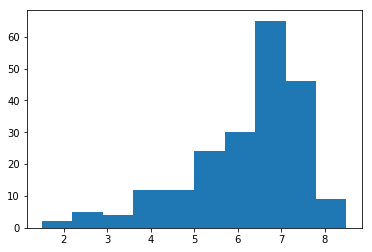

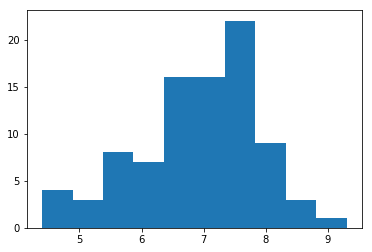

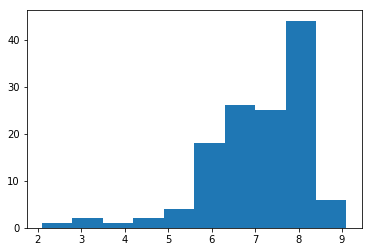

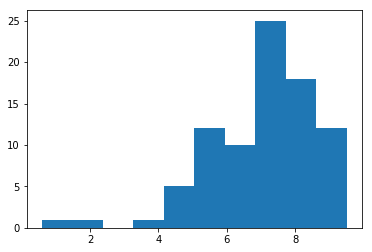

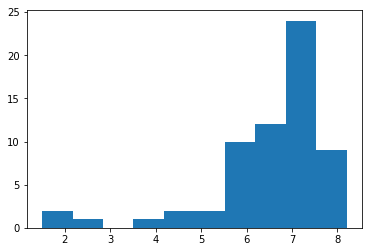

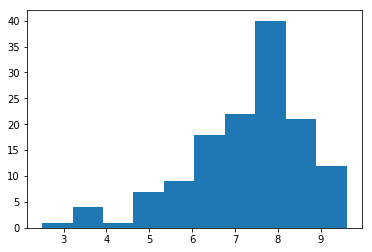

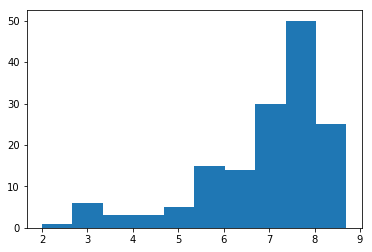

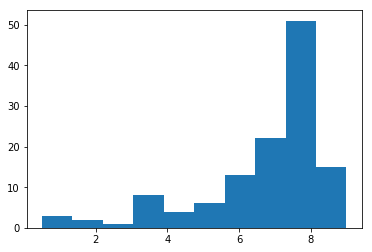

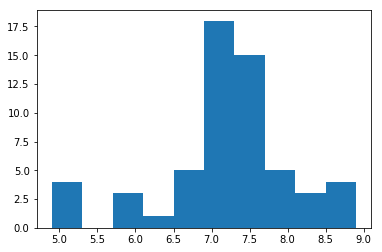

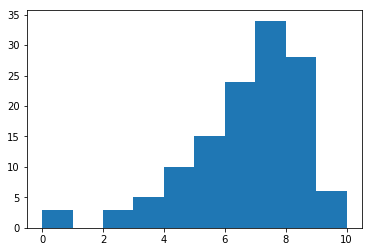

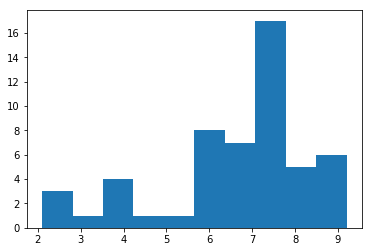

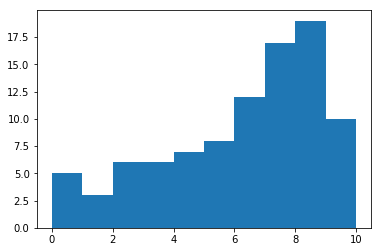

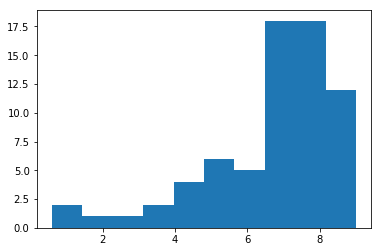

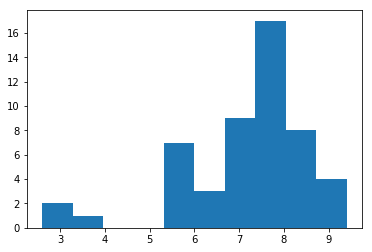

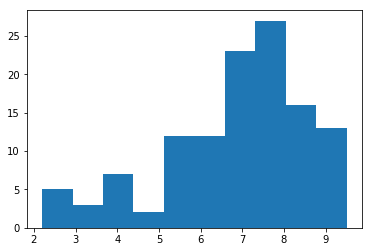

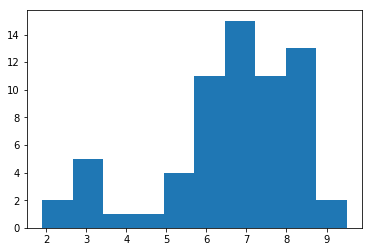

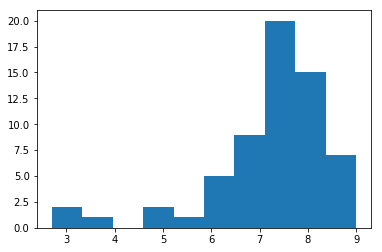

In [72]:
#plot sample distributions to check for normality
for value in author_scores_50.values():
    plt.hist(value['scores'])
    plt.show()

In most cases the data in the samples seem to be approximately normally distribuited

In [62]:
#get a list of authors that seem to be biased (where we reject Null Hypothesis that states that the means is
#the same as population's mean)

functions.get_biased_authors(author_scores_30, scores_mean, scores_std, 0.05)
    

[]

The function returned an empty list, which means that in no case we could reject the null hypothesis.